In [1]:
import torch
import torchvision
print(torch.__version__) 
print(torchvision.__version__)

2.0.1
0.15.2


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())

True
1
Tesla P100-PCIE-12GB


#setup repo

(mycondapy310) [010796032@coe-hpc1 DeepDataMiningLearning]$ conda install -c conda-forge pycocotools
(mycondapy310) [010796032@coe-hpc1 DeepDataMiningLearning]$ python3 -m pip install flit
(mycondapy310) [010796032@coe-hpc1 DeepDataMiningLearning]$ flit install --symlink

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
import os
os.environ['TORCH_HOME'] = '/data/cmpe249-fa23/torchhome/'
DATAPATH='/data/cmpe249-fa23/torchvisiondata'

In [206]:
# https://github.com/pytorch/vision/blob/main/references/detection/transforms.py

from typing import Dict, List, Optional, Tuple, Union

import torch
import torchvision
from torch import nn, Tensor
from torchvision import ops
from torchvision.transforms import functional as F, InterpolationMode, transforms as T


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class PILToTensor(nn.Module):
    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        image = F.pil_to_tensor(image)
        return image, target

class ToDtype(nn.Module):
    def __init__(self, dtype: torch.dtype, scale: bool = False) -> None:
        super().__init__()
        self.dtype = dtype
        self.scale = scale

    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        if not self.scale:
            return image.to(dtype=self.dtype), target
        image = F.convert_image_dtype(image, self.dtype)
        return image, target

class RandomHorizontalFlip(T.RandomHorizontalFlip):
    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            if target is not None:
                _, _, width = F.get_dimensions(image)
                target["boxes"][:, [0, 2]] = width - target["boxes"][:, [2, 0]]
                if "masks" in target:
                    target["masks"] = target["masks"].flip(-1)
                if "keypoints" in target:
                    keypoints = target["keypoints"]
                    keypoints = _flip_coco_person_keypoints(keypoints, width)
                    target["keypoints"] = keypoints
        return image, target

In [207]:
def get_transform(train):
    transforms = []
    transforms.append(PILToTensor())
    transforms.append(ToDtype(torch.float, scale=True))
    # if train:
    #     transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

In [13]:
#from torchvision.transforms import v2 as T #module 'torchvision.transforms.v2' has no attribute 'ToPureTensor'
#Since v0.15.0 torchvision provides new Transforms API to easily write data augmentation pipelines for Object Detection and Segmentation tasks.
# def get_transform(train):
#     transforms = []
#     if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
#     transforms.append(T.ToDtype(torch.float, scale=True))
#     transforms.append(T.ToPureTensor())
#     return T.Compose(transforms)

In [208]:
#https://github.com/pytorch/vision/blob/main/references/detection/coco_utils.py
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, transforms):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        image_id = self.ids[idx]
        target = dict(image_id=image_id, annotations=target)
        if self._transforms is not None:
            img, target = self._transforms(img, target)
        return img, target

def _coco_remove_images_without_annotations(dataset, cat_list=None):
    def _has_only_empty_bbox(anno):
        return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)

    def _has_valid_annotation(anno):
        # if it's empty, there is no annotation
        if len(anno) == 0:
            return False
        # if all boxes have close to zero area, there is no annotation
        if _has_only_empty_bbox(anno):
            return False
        return False

    ids = []
    for ds_idx, img_id in enumerate(dataset.ids):
        ann_ids = dataset.coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anno = dataset.coco.loadAnns(ann_ids)
        if cat_list:
            anno = [obj for obj in anno if obj["category_id"] in cat_list]
        if _has_valid_annotation(anno):
            ids.append(ds_idx)

    dataset = torch.utils.data.Subset(dataset, ids)
    return dataset


def get_coco(root, image_set, transforms, mode="instances"):
    anno_file_template = "{}_{}2017.json"
    PATHS = {
        "train": ("train2017", os.path.join("annotations", anno_file_template.format(mode, "train"))),
        "val": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val"))),
        # "train": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val")))
    }
    print(PATHS)

    img_folder, ann_file = PATHS[image_set]
    img_folder = os.path.join(root, img_folder)
    ann_file = os.path.join(root, ann_file)

    t = []
    if transforms is not None:
        t.append(transforms)
    transforms = Compose(t)

    dataset = CocoDetection(img_folder, ann_file, transforms=transforms)

    #if image_set == "train":
        #dataset = _coco_remove_images_without_annotations(dataset)

    # dataset = torch.utils.data.Subset(dataset, [i for i in range(500)])

    return dataset

In [209]:
data_path='/data/cmpe249-fa23/COCOoriginal/'
ann_file='/data/cmpe249-fa23/COCOoriginal/annotations/instances_train2017.json'
is_train = True
mode="instances"
ds_train = get_coco(
        root=data_path,
        image_set="train",
        transforms=get_transform(is_train),
        mode=mode,
    )

{'train': ('train2017', 'annotations/instances_train2017.json'), 'val': ('val2017', 'annotations/instances_val2017.json')}
loading annotations into memory...
Done (t=25.70s)
creating index...
index created!


In [210]:
!ls /data/cmpe249-fa23/COCOoriginal/

annotations  annotations_trainval2017.zip  getcoco.sh  train2017  val2017


In [211]:
print("Dataset len",len(ds_train))

Dataset len 118287


In [212]:
sample = ds_train[20]

In [213]:
img, target = sample

In [214]:
target['image_id']

109

In [215]:
len(target['annotations'])

8

In [216]:
type(target['annotations'])

list

In [217]:
target['annotations'][0]

{'segmentation': [[539.81,
   305.46,
   539.72,
   301.32,
   542.12,
   299.3,
   542.99,
   298.91,
   542.99,
   298.91,
   543.09,
   296.99,
   543.18,
   296.12,
   544.15,
   295.45,
   545.3,
   296.51,
   545.59,
   297.37,
   546.26,
   296.89,
   555.7,
   298.34,
   561.28,
   297.57,
   562.63,
   302.19,
   561.86,
   302.96,
   559.07,
   301.03,
   557.72,
   301.22,
   557.72,
   301.22,
   557.14,
   303.73,
   556.47,
   304.11,
   556.47,
   304.31,
   560.61,
   309.89,
   559.55,
   310.76,
   555.7,
   305.94,
   555.41,
   304.5,
   553.68,
   304.21,
   553.97,
   307.96,
   557.05,
   312.78,
   555.7,
   313.84,
   552.43,
   308.54,
   550.88,
   303.73,
   548.48,
   303.25,
   547.23,
   305.27,
   548.0,
   308.45,
   547.52,
   309.12,
   547.61,
   309.22,
   549.73,
   312.78,
   549.73,
   313.07,
   547.9,
   313.74,
   543.47,
   306.33,
   544.15,
   302.67,
   544.15,
   302.67,
   540.97,
   303.82,
   542.03,
   307.96,
   542.03,
   308.45,
  

In [218]:
img.shape

torch.Size([3, 416, 640])

In [219]:
imgdata=img.permute(1, 2, 0) #CHW -> HWC
imgdata.shape

torch.Size([416, 640, 3])

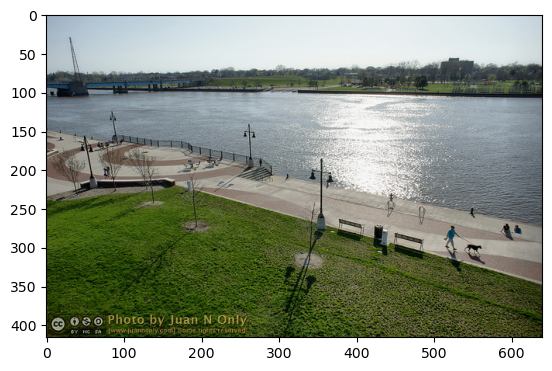

In [220]:
import matplotlib.pyplot as plt
plt.imshow(imgdata)

In [221]:
ids = [anno['category_id'] for anno in target['annotations']]

In [222]:
ids

[18, 1, 1, 1, 15, 15, 1, 1]

In [232]:
boxes = [anno['bbox'] for anno in target['annotations']]

In [233]:
boxes

[[539.72, 295.45, 22.91, 18.39],
 [512.89, 271.42, 21.24, 32.73],
 [585.88, 268.35, 18.19, 22.82],
 [548.02, 249.59, 4.55, 8.11],
 [376.6, 261.49, 34.46, 23.75],
 [448.37, 281.77, 40.29, 23.19],
 [74.56, 197.85, 6.29, 15.28],
 [604.26, 271.45, 9.19, 11.3]]

In [225]:
import cv2
im = cv2.cvtColor(imgdata.numpy(), cv2.COLOR_BGR2RGB)

In [226]:
def compute_color_for_labels(label):
    """
    Simple function that adds fixed color depending on the class
    """
    palette = (2 ** 11 - 1, 2 ** 15 - 1, 2 ** 20 - 1)
    #color = [int((p * (label ** 2 - label + 1)) % 255) for p in palette]
    color = [int((p * ((label+5*label) ** 2 - label + 1)) % 255) for p in palette]
    return tuple(color)
    
def show_image_bbxyxy(image, pred_bbox, pred_ids, title, savefigname=None):
    """Show a camera image and the given camera labels."""
        
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))
    boxnum=len(pred_bbox)
    pred_bbox = [[(i[0], i[1]), (i[2], i[3])] for i in pred_bbox]
    #print(boxnum)
    if len(pred_ids)<1:
        print("No object detected")
        return image
    else:
        
        #print(pred_labels)
        for i in range(boxnum):#patch in pred_bbox:
            patch=pred_bbox[i]
            #print(patch)
            colorlabel=compute_color_for_labels(pred_ids[i]) #INSTANCE_Color[label]
            #print(colorlabel)#RGB value 0-255
            colorlabelnormalized = [float(i)/255 for i in colorlabel] #0-1
            #label=pred_labels[i]
            #print(label)
            ax.add_patch(Rectangle(
            xy=patch[0],#(patch[0], patch[1]), #xmin ymin
            width=patch[1][0]-patch[0][0],#patch[2] - patch[0],
            height=patch[1][1]-patch[0][1],#patch[3] - patch[1],
            linewidth=4,
            edgecolor=colorlabelnormalized,#"red",
            facecolor='none'))
            #ax.text(patch[0][0], patch[0][1], label, color=colorlabelnormalized, fontsize=12)
            #ax.text(patch[0][0], patch[0][1], label, bbox=dict(facecolor='red', alpha=0.5))#fontsize=8)
        
    ax.imshow(image)
    
    ax.title.set_text(title)
    ax.grid(False)
    ax.axis('off')
    
    if savefigname is not None:
        fig.savefig(savefigname)

In [234]:
boxes_xyxy = [[box[0], box[1], box[0]+box[2], box[1]+box[3]] for box in boxes] #xywh->xyxy
boxes_xyxy

[[539.72, 295.45, 562.63, 313.84],
 [512.89, 271.42, 534.13, 304.15000000000003],
 [585.88, 268.35, 604.07, 291.17],
 [548.02, 249.59, 552.5699999999999, 257.7],
 [376.6, 261.49, 411.06, 285.24],
 [448.37, 281.77, 488.66, 304.96],
 [74.56, 197.85, 80.85000000000001, 213.13],
 [604.26, 271.45, 613.45, 282.75]]

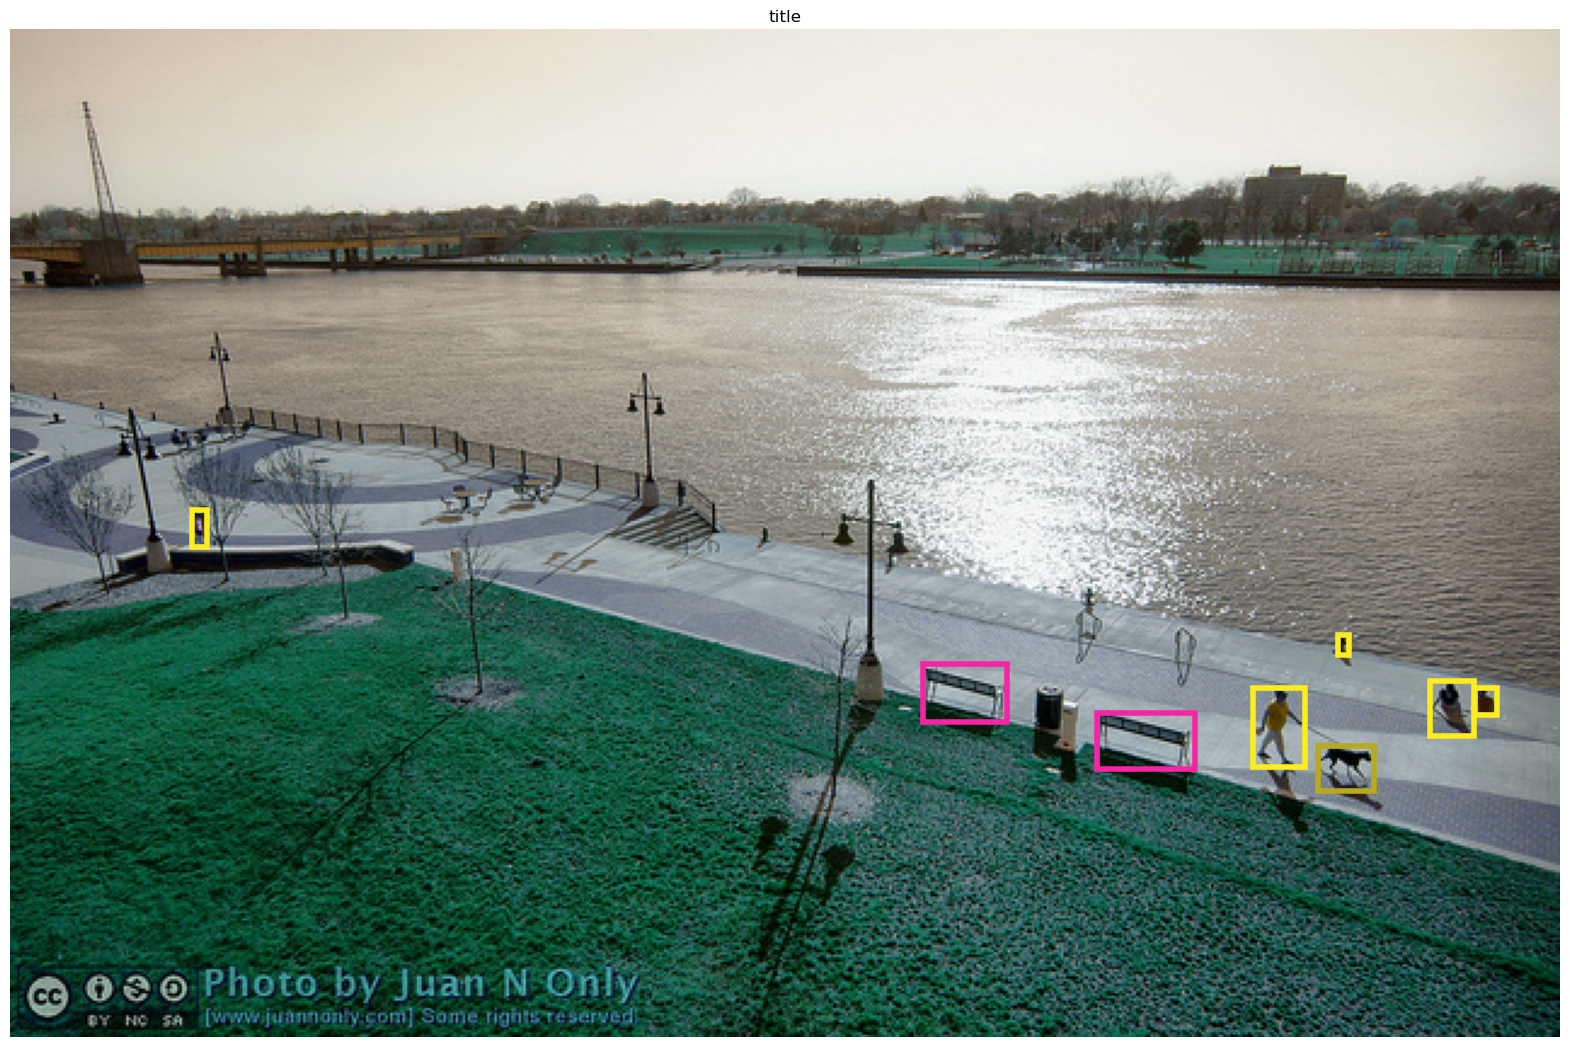

In [235]:
show_image_bbxyxy(im, boxes_xyxy, ids, 'title')

In [236]:
from matplotlib.patches import Rectangle
def myshowoneimage(img, target, cmap=None):
    """Show a camera image and the given camera labels."""
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))
    
    imgdata=img.permute(1, 2, 0)
    imgdata.shape

    boxes = [anno['bbox'] for anno in target['annotations']]
    
    #boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(dataset[1]['boxes'].detach().numpy())]
    for i in range(len(boxes)): #[xmin, ymin, width, height], 1280, 1920
        box=boxes[i] #[xmin, ymin, xmax, ymax]
        #width=box[2]-box[0]
        #height=box[3]-box[1]
        print(box)
        ax.add_patch(Rectangle(
            xy=(box[0], box[1]), #(boxes[i][0][0], boxes[i][0][1]),
            width=box[2], #boxes[i][1][0]-boxes[i][0][0],#x-axis
            height=box[3], #boxes[i][1][1]-boxes[i][0][1],#y-axis
            linewidth=2,
            edgecolor='red',
            facecolor='none'))    
        ax.text(100, 200, 'test')

    # Show the camera image.
    plt.imshow(imgdata, cmap=cmap)
    ax.grid(True)
    #plt.axis('off')
    fig.savefig("annotationoneimage.png")
    

In [237]:
myshowoneimage(img, target)

[539.72, 295.45, 22.91, 18.39]
[512.89, 271.42, 21.24, 32.73]
[585.88, 268.35, 18.19, 22.82]
[548.02, 249.59, 4.55, 8.11]
[376.6, 261.49, 34.46, 23.75]
[448.37, 281.77, 40.29, 23.19]
[74.56, 197.85, 6.29, 15.28]
[604.26, 271.45, 9.19, 11.3]


In [239]:
dataset=ds_train
num_classes=91

In [240]:
data_path='/data/cmpe249-fa23/COCOoriginal/'
ann_file='/data/cmpe249-fa23/COCOoriginal/annotations/instances_train2017.json'
is_train = False
mode="instances"
dataset_test = get_coco(
        root=data_path,
        image_set="val",
        transforms=get_transform(is_train),
        mode=mode,
    )

{'train': ('train2017', 'annotations/instances_train2017.json'), 'val': ('val2017', 'annotations/instances_val2017.json')}
loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


In [241]:
train_sampler = torch.utils.data.RandomSampler(dataset)
test_sampler = torch.utils.data.SequentialSampler(dataset_test)

In [243]:
BATCH_SIZE=16
train_batch_sampler = torch.utils.data.BatchSampler(train_sampler, BATCH_SIZE, drop_last=True)

def collate_fn(batch):
    return tuple(zip(*batch))
train_collate_fn = collate_fn

In [244]:
WORKERS = 4
data_loader = torch.utils.data.DataLoader(
    dataset, batch_sampler=train_batch_sampler, num_workers=WORKERS, collate_fn=train_collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, sampler=test_sampler, num_workers=WORKERS, collate_fn=collate_fn
)

In [246]:
print("Creating model")
from torchvision.models import get_model, get_model_weights, get_weight, list_models
def get_torchvision_detection_models(modelname, box_score_thresh=0.9):
    weights_enum = get_model_weights(modelname) #<enum 'FasterRCNN_MobileNet_V3_Large_320_FPN_Weights'>
    weights = weights_enum.DEFAULT #get the default weights
    preprocess = weights.transforms()
    classes = weights.meta["categories"]
    pretrained_model=get_model(modelname, box_score_thresh=0.9, weights="DEFAULT")
    return pretrained_model, preprocess, weights, classes

modelname='fasterrcnn_resnet50_fpn_v2'
pretrained_model, preprocess, weights, classes = get_torchvision_detection_models(modelname)

Creating model


In [247]:
pretrained_model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [248]:
parameters = [p for p in pretrained_model.parameters() if p.requires_grad]

In [249]:
optimizer = torch.optim.AdamW(parameters, lr=0.02, weight_decay=1e-4)

In [259]:
from DeepDataMiningLearning.detection import utils

In [262]:
from DeepDataMiningLearning.detection.engine import evaluate

In [263]:
evaluate(pretrained_model, data_loader_test, device=device)

Test:  [   0/5000]  eta: 1:19:52  model_time: 0.1473 (0.1473)  evaluator_time: 0.0091 (0.0091)  time: 0.9585  data: 0.7987  max mem: 1134
Test:  [ 100/5000]  eta: 0:10:48  model_time: 0.1161 (0.1167)  evaluator_time: 0.0032 (0.0037)  time: 0.1236  data: 0.0018  max mem: 1137
Test:  [ 200/5000]  eta: 0:10:17  model_time: 0.1161 (0.1170)  evaluator_time: 0.0030 (0.0037)  time: 0.1242  data: 0.0017  max mem: 1138
Test:  [ 300/5000]  eta: 0:09:59  model_time: 0.1215 (0.1172)  evaluator_time: 0.0033 (0.0037)  time: 0.1272  data: 0.0017  max mem: 1138
Test:  [ 400/5000]  eta: 0:09:44  model_time: 0.1170 (0.1175)  evaluator_time: 0.0032 (0.0037)  time: 0.1256  data: 0.0017  max mem: 1138
Test:  [ 500/5000]  eta: 0:09:31  model_time: 0.1196 (0.1178)  evaluator_time: 0.0033 (0.0036)  time: 0.1255  data: 0.0018  max mem: 1138
Test:  [ 600/5000]  eta: 0:09:16  model_time: 0.1159 (0.1177)  evaluator_time: 0.0032 (0.0036)  time: 0.1219  data: 0.0018  max mem: 1138
Test:  [ 700/5000]  eta: 0:09:03  

In [265]:
!pwd

/home/010796032/MyRepo/DeepDataMiningLearning/DeepDataMiningLearning


In [266]:
modelname = 'fasterrcnn_resnet50_fpn_v2'
checkpointpath = './detection/model_3.pth'
fasterrcnn_model=get_model(modelname, box_score_thresh=0.9, weights=None)
checkpoint = torch.load(checkpointpath, map_location="cpu")
fasterrcnn_model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [268]:
checkpoint.keys()

dict_keys(['model', 'optimizer', 'lr_scheduler', 'args', 'epoch'])

In [269]:
checkpoint['epoch']

3

In [270]:
checkpoint['args']

Namespace(data_path='/data/cmpe249-fa23/COCOoriginal/', dataset='coco', model='fasterrcnn_resnet50_fpn_v2', device='cuda', batch_size=8, epochs=20, workers=4, opt='sgd', lr=0.02, momentum=0.9, weight_decay=0.0001, norm_weight_decay=None, lr_scheduler='multisteplr', lr_step_size=8, lr_steps=[16, 22], lr_gamma=0.1, print_freq=5, output_dir='.', resume='', start_epoch=0, aspect_ratio_group_factor=3, rpn_score_thresh=None, trainable_backbone_layers=None, data_augmentation='hflip', sync_bn=False, test_only=False, use_deterministic_algorithms=False, world_size=1, dist_url='env://', weights=None, weights_backbone=None, amp=False, use_copypaste=False, backend='pil', use_v2=False, distributed=False)

In [271]:
fasterrcnn_model.to(device)
evaluate(fasterrcnn_model, data_loader_test, device=device)

Test:  [   0/5000]  eta: 1:27:22  model_time: 0.1522 (0.1522)  evaluator_time: 0.0179 (0.0179)  time: 1.0484  data: 0.8751  max mem: 1297
Test:  [ 100/5000]  eta: 0:11:04  model_time: 0.1167 (0.1190)  evaluator_time: 0.0033 (0.0033)  time: 0.1247  data: 0.0022  max mem: 1306
Test:  [ 200/5000]  eta: 0:10:31  model_time: 0.1202 (0.1190)  evaluator_time: 0.0031 (0.0033)  time: 0.1264  data: 0.0020  max mem: 1306
Test:  [ 300/5000]  eta: 0:10:10  model_time: 0.1220 (0.1189)  evaluator_time: 0.0031 (0.0031)  time: 0.1278  data: 0.0021  max mem: 1306
Test:  [ 400/5000]  eta: 0:09:53  model_time: 0.1192 (0.1190)  evaluator_time: 0.0032 (0.0031)  time: 0.1266  data: 0.0024  max mem: 1306
Test:  [ 500/5000]  eta: 0:09:40  model_time: 0.1198 (0.1192)  evaluator_time: 0.0032 (0.0031)  time: 0.1280  data: 0.0024  max mem: 1306
Test:  [ 600/5000]  eta: 0:09:25  model_time: 0.1159 (0.1190)  evaluator_time: 0.0030 (0.0031)  time: 0.1253  data: 0.0022  max mem: 1306
Test:  [ 700/5000]  eta: 0:09:12  

# Kitti

In [275]:
!ls /data/cmpe249-fa23/

Cityscapes	  Kitti			   torchhome
coco		  kittiall		   torchvisiondata
COCOoriginal	  myros2humblecuda117	   Waymo200
Huggingfacecache  myros2humblecuda117.tar  waymotrain200cocoyolo
ImageClassData	  nuScenes


In [278]:
!ls /data/cmpe249-fa23/torchvisiondata/Kitti

raw


In [280]:
rootPath = '/data/cmpe249-fa23/torchvisiondata/'
mykitti = datasets.Kitti(root=rootPath, train= True, transform = None, target_transform = None, download = False)


In [281]:
print(len(mykitti))

7481


In [283]:
img, targets=mykitti[0]

In [284]:
img #PIL image

In [286]:
len(targets) #list of objects

5

In [287]:
targets[0] #bbox format: [xmin, ymin, xmax, ymax]

{'type': 'Cyclist',
 'truncated': 0.0,
 'occluded': 0,
 'alpha': -1.54,
 'bbox': [668.79, 158.64, 697.75, 243.27],
 'dimensions': [1.82, 0.59, 1.89],
 'location': [1.65, 1.52, 16.44],
 'rotation_y': -1.44}

In [338]:
def get_transform(train):
    transforms = []
    transforms.append(PILToTensor())
    transforms.append(ToDtype(torch.float, scale=True))
    # if train:
    #     transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

In [339]:
from DeepDataMiningLearning.detection.dataset import MyKittiDetection

In [340]:
rootPath = '/data/cmpe249-fa23/torchvisiondata/Kitti'
kittidataset = MyKittiDetection(rootPath, train=True, transform=get_transform(is_train))

In [341]:
len(kittidataset)

7481

In [342]:
img, target = kittidataset[0]

TypeError: 'module' object is not callable

In [310]:
class MyKittiDetection(torchvision.datasets.Kitti):
    #mykitti = datasets.Kitti(root=rootPath, train= True, transform = get_transform(is_train, args), target_transform = None, download = False)
    def __init__(self, rootPath, transforms):
        print("rootPath:",rootPath)
        super().__init__(root=rootPath, train= True)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        image_id = idx #self.ids[idx]
        target = dict(image_id=image_id, annotations=target)
        if self._transforms is not None:
            img, target = self._transforms(img, target)
        return img, target

In [311]:
def get_kittidataset(data_path, is_train, transforms):
    t = []
    if transforms is not None:
        t.append(transforms)
    transforms = Compose(t)

    dataset = MyKittiDetection(data_path,transforms=transforms)
    return dataset

In [312]:
rootPath = '/data/cmpe249-fa23/torchvisiondata/'
kittidataset=get_kittidataset(rootPath, is_train=True, transforms=get_transform(train=True))

rootPath: /data/cmpe249-fa23/torchvisiondata/


RuntimeError: Dataset not found. You may use download=True to download it.

In [22]:
# split the dataset in train and test set
indices = torch.randperm(len(mycoco_train)).tolist()
idxsplit=int(len(indices)*0.80)#159948
dataset_train = torch.utils.data.Subset(mycoco_train, indices[:idxsplit])
mycoco_train.transforms = get_transform(train=True)
dataset_test = torch.utils.data.Subset(mycoco_train, indices[idxsplit+1:])

In [23]:
print("Dataset train len",len(dataset_train))

Dataset train len 94629


In [24]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [25]:
BATCH_SIZE=8
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=collate_fn)

Torchvision datasets preserve the data structure and types as it was intended by the datasets authors. So by default, the output structure may not always be compatible with the models or the transforms.

To overcome that, we can use the wrap_dataset_for_transforms_v2() function. For CocoDetection, this changes the target structure to a single dictionary of lists:

In [9]:
import torch.utils.data
from torchvision import models, tv_tensors
from torchvision.transforms import v2

ImportError: cannot import name 'tv_tensors' from 'torchvision' (/home/010796032/miniconda3/envs/mycondapy310/lib/python3.10/site-packages/torchvision/__init__.py)

In [8]:
dataset = datasets.wrap_dataset_for_transforms_v2(mycoco_train, target_keys=("boxes", "labels", "masks"))

sample = dataset[0]
img, target = sample
print(f"{type(img) = }\n{type(target) = }\n{target.keys() = }")
print(f"{type(target['boxes']) = }\n{type(target['labels']) = }\n{type(target['masks']) = }")

/home/010796032/miniconda3/envs/mycondapy310/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/010796032/miniconda3/envs/mycondapy310/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feed

TypeError: wrap_dataset_for_transforms_v2() got an unexpected keyword argument 'target_keys'

In [ ]:
from torchvision.models import get_model, get_model_weights, get_weight, list_models
detection_models = list_models(module=torchvision.models.detection)
def get_torchvision_detection_models(modelname, box_score_thresh=0.9):
    weights_enum = get_model_weights(modelname) #<enum 'FasterRCNN_MobileNet_V3_Large_320_FPN_Weights'>
    weights = weights_enum.DEFAULT #get the default weights
    preprocess = weights.transforms()
    classes = weights.meta["categories"]
    pretrained_model=get_model(modelname, box_score_thresh=0.9, weights="DEFAULT")
    return pretrained_model, preprocess, weights, classes

In [ ]:
from torchvision.io.image import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

def test_inference(modelname, imgpath):
    img = read_image(imgpath)
    pretrained_model, preprocess, weights, classes = get_torchvision_detection_models(modelname)
    pretrained_model.eval()
    #Apply inference preprocessing transforms
    batch = [preprocess(img)]
    prediction = pretrained_model(batch)[0]
    labels = [classes[i] for i in prediction["labels"]]
    box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                            labels=labels,
                            colors="red",
                            width=4, font_size=40)
    im = to_pil_image(box.detach())
    return im

In [ ]:
imgpath="../sampledata/sjsupeople.jpg"
modelname='fasterrcnn_mobilenet_v3_large_320_fpn'
im = test_inference(modelname, imgpath)